# PRÁCTICA 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import MinMaxScaler

import random

## CARGA DE DATOS

Creamos una carpeta llamada datos en la que vamos a importar el archivo zip.



In [2]:
!mkdir datos

Para cargar los datos utilizamos un fragmento de código de una página web cuyo link dejamos más abajo, de esta forma vamos a importar el csv desde una URL externa, en nuestro caso de Google Drive.

Link: https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

In [3]:
import requests


def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

Aplicamos la función definida anteriormente download_file_from_google_drive para nuestro caso con nuestro link:

https://docs.google.com/file/d/1o9GAki6WjoM6dA8G9JFBFJUAB2J5w4zd

In [4]:
file_id = '1o9GAki6WjoM6dA8G9JFBFJUAB2J5w4zd'
destination = 'datos/datos.zip'
download_file_from_google_drive(file_id, destination)

In [5]:
!unzip datos/datos.zip -d datos && rm datos/datos.zip

Archive:  datos/datos.zip
  inflating: datos/okcupid_profiles.csv  


## PRE-PROCESAMIENTO

Vamos a cargar las librerias de pandas, numpy y matplotlib.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Cargamos los ficheros csv en un dataframe de pandas.

In [7]:
data = pd.read_csv('datos/okcupid_profiles.csv',
                   sep=',',
                   engine='python',g
                   encoding='utf-8',
                   error_bad_lines=False)

Observamos una descripción de los datos


In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,59946.0,32.340290,9.452779,18.0,26.0,30.0,37.0,110.0
height,59943.0,68.295281,3.994803,1.0,66.0,68.0,71.0,95.0
income,59946.0,20033.222534,97346.192104,-1.0,-1.0,-1.0,-1.0,1000000.0


Vamos a ver cuantos valores de -1 tiene la variable Income

In [9]:
data.income.value_counts()

-1          48442
 20000       2952
 100000      1621
 80000       1111
 30000       1048
 40000       1005
 50000        975
 60000        736
 70000        707
 150000       631
 1000000      521
 250000       149
 500000        48
Name: income, dtype: int64

De estas variables numéricas:
  - age: dato numérico que utilizaremos
  - height: es un dato numérico pero no lo utilizaremos, ya que al ser una red de contactos, queremos ver que personas son mas compatibles. El tener la misma altura no hace que 2 personas sean mas compatibles. 
  - income: hay muchos valores -1 (no lo ha contestado o no tenía ingresos), en concreto 41539, así que no lo utilizaremos, ya que sesgaría a nuestro algoritmo



Vimos que la variable Education tenía muchas categorías distintas, por lo que decidimos agruparlas en 3 categorías:
- high (H)  : nivel alto de estudios
- medium (M) : nivel medio de estudios
- low (L) : nivel bajo de estudios

In [10]:
data.education.value_counts()

graduated from college/university    23959
graduated from masters program        8961
working on college/university         5712
working on masters program            1683
graduated from two-year college       1531
graduated from high school            1428
graduated from ph.d program           1272
graduated from law school             1122
working on two-year college           1074
dropped out of college/university      995
working on ph.d program                983
college/university                     801
graduated from space camp              657
dropped out of space camp              523
graduated from med school              446
working on space camp                  445
working on law school                  269
two-year college                       222
working on med school                  212
dropped out of two-year college        191
dropped out of masters program         140
masters program                        136
dropped out of ph.d program            127
dropped out

Agrupos la variable de educacion en high (H), medium (M) y low (L)

In [11]:
education_map = {'graduated from college/university': 'H',
            'graduated from masters program': 'H',
            'working on college/university': 'M',
            'working on masters program': 'H',
            'graduated from two-year college': 'H',
            'graduated from high school': 'H',
            'graduated from ph.d program': 'H',
            'graduated from law school': 'H',
            'working on two-year college': 'H',
            'dropped out of college/university': 'M',
            'working on ph.d program': 'H',
            'college/university': 'H',
            'graduated from space camp': 'H',
            'dropped out of space camp': 'M',
            'graduated from med school': 'H',
            'working on space camp': 'H',
            'working on law school': 'H',
            'two-year college': 'H',
            'working on med school': 'H',
            'dropped out of two-year college': 'M',
            'dropped out of masters program': 'H',
            'masters program': 'M',
            'dropped out of ph.d program': 'M',
            'dropped out of high school': 'L',
            'high school': 'L',
            'working on high school': 'L',
            'space camp': 'H',
            'ph.d program': 'H',
            'law school': 'H',
            'dropped out of law school': 'M',
            'dropped out of med school': 'M',
            'med school': 'M'}

data.education = data.education.fillna('high school').map(lambda x: education_map[x])





En la siguiente celda hacemos print de las variables que tienen menos de 20 valores únicos, las cuales consideraremos como variables categóricas. A su lado mostramos el número de categorías que hay en cada feature.

  De estas variables categóricas, solo utilizaremos las que creemos que pueden ayudar al algoritmo a que encuentre más facil similitudes entre las personas. También las codificamos mediante OneHot encoding y después aplicamos un MinMax para codificar 

In [12]:
for c in data:
    u = len(data[c].unique())
    if u<20: print(c, u)

status 5
sex 2
orientation 3
body_type 13
diet 19
drinks 7
drugs 4
education 3
income 13
offspring 16
pets 16
smokes 6


In [13]:
X_onehot = pd.get_dummies(data[['status', 'body_type', 'diet', 'drinks', 'education',
                                'drugs', 'offspring', 'pets', 'smokes']])

X_numerical = MinMaxScaler().fit_transform(data['age'].values.reshape(-1, 1))

Para las variables textuales lo que haremos será agruparlas todas en una misma feature y utilizar el LDA para sacar los topics de los que hablan. 

La distribución final de esos topics de los que hablan en sus biografías lo utilizaremos como feature para entrenar a nuestro algoritmo. 

Para poder entrenar el algoritmo utilizamos el método de CountVectorizer y luego aplicamos el LDA. 

Después transformamos esos datos textuales en un vector de features, que representa esa dstribución de topics.

Por último concatemos los vectores de valores numéricos, las variables categóricas obtenidas mediante one-hot y esta distribución de topics para entrenar nuestros algoritmos.

In [14]:
data['text'] = data[['essay0','essay1','essay2','essay3','essay4',
                     'essay5','essay6','essay7','essay8','essay9']].fillna(' ').agg('-'.join, axis=1)

In [15]:
vectorizer = CountVectorizer(max_df=0.95, max_features=1000, stop_words='english')
vectorized = vectorizer.fit_transform(data['text'])

In [16]:
lda = LatentDirichletAllocation(n_components=20,
                                learning_method='online',
                                random_state=1337)
lda.fit(vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=1337,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [17]:
text_topic = lda.transform(vectorized)

In [18]:
X = np.concatenate([X_numerical, X_onehot, text_topic], axis=1)

Aquí utilizamos unicamente el 30% de los datos para poder ir más rápido. El entrenamiento con todos los datos tarda MUCHO tiempo.

Para poder entrenarlo con todo, ponemos: ALL_DATA = True

In [19]:
ALL_DATA = False

if ALL_DATA:
    # utilizamos TODOS los datos para entrenar
    idx = np.array(range(len(X)))
else:
    # solamente utilizamos un 30% de los datos para entrenar e ir más rápido
    idx = random.sample(range(len(X)), int(len(X)*0.3))
    # usar stratified --> hacemos random sampling, por lo que no hace falta usar stratified



## ENTRENAMIENTO Y VALIDACIÓN

### VISUALIZACIÓN DEL CONJUNTO DE DATOS

Ahora realizamos un entrenamiento del algoritmos t-SNE para poder visualizar en dos dimensiones nuestros datos de entenamiento. Cuando apliquemos los algoritmos de clustering, seguiremos utilizando esta misma visualización, pero colorearemos de colores distintos los puntos que pertenezcan a los distintos clusters.


In [20]:
tsne = TSNE(n_components=2).fit_transform(X[idx])

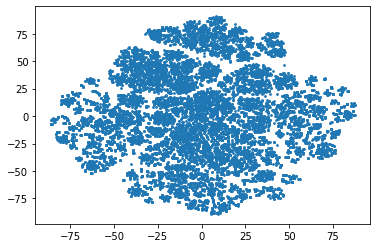

In [21]:
plt.scatter(tsne[:, 0], tsne[:, 1], s=3)

Aquí reducimos la dimensionalidad de nuestro set de entrenamiendo de forma que no tengamos tantas features y podamos entrenar los algoritmos más rápidamente, ya que al calcular las distintas distancias, se hace de forma más eficiente si el número de features es menor.

Para ello utilizaremos el algoritmo de PCA. Nos quedaremos con el número de componentes que nos explique al menos el 95% de la varianza. En la siguiente celda imprimimos por pantalla el número de componentes al lado del porcentaje de la varianza explicada.

In [22]:
explained_var = []
for i in range(2, 60, 5):
    pca = PCA(n_components=i).fit(X[idx])
    ev = pca.explained_variance_ratio_.sum()
    print(i, '-->', ev)
    explained_var.append(ev)

2 --> 0.16148839240695884
7 --> 0.4283753638021776
12 --> 0.5798320683823612
17 --> 0.6829565350955735
22 --> 0.7612471177242097
27 --> 0.8218823888574992
32 --> 0.8675852443858372
37 --> 0.9029163700534325
42 --> 0.9274633461542451
47 --> 0.9457218867942278
52 --> 0.9596692436284242
57 --> 0.9699634329462075


En la siguiente gráfica mostramos la varianza explicada con respecto al número de componentes. Obviamente, cuantas más componentes tengamos, más varianza podremos explicar.

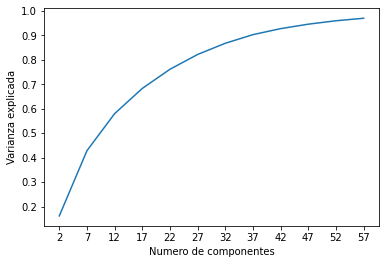

In [34]:
plt.xlabel('Numero de componentes')
plt.ylabel('Varianza explicada')
plt.xticks(range(len(explained_var)), range(2, 60, 5))
plt.plot(explained_var)

Ampliamos la gráfica para ver que cuando el número de componentes es igual a 52, la varianza es 0.95

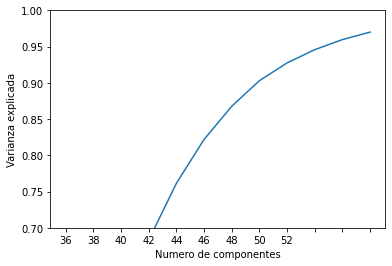

In [50]:
plt.ylim(0.7,1)
plt.xlabel('Numero de componentes')
plt.ylabel('Varianza explicada')
plt.xticks(range(len(explained_var)), range(36, 53, 2))
plt.plot(explained_var)

En base a lo anterior, utilizamos un número de componentes igual a 52, y hacemos una transformación de nuestros datos a una varaible que se llama X_pca, que será la matriz que utilizaremos para entrenar nuestro algoritmo.

In [24]:
X_pca = PCA(n_components=52).fit_transform(X[idx])

Tambien hacemos una reducción de dimensionalidad 
mediante ISOMAP, y comprobaremos más tarde cuál es la que mejor funciona cuando apliquemos los algoritmos de clustering. Utilizaremos el mismo numero de componentes que en el PCA.

Al entrenar este modelo con todos estos datos, nos quedamos sin memoria RAM, por lo que no podemos utilizar este método.

In [25]:
# X_isomap = Isomap(n_components=52).fit_transform(X[idx])

Probamos con 4 algoritmos distintos: K-Means, Clustering Espectral, Clustering Aglomerativo y DBSCAN. Para cada uno de ellos hacemos un barrido de distintos número de clusters y calculamos su silhouette score. 

Un número mayor de Silhouette Score indicará que los elementos pertenecientes a un clústers están cerca de los otros elementos pertenecientes a ese clusters y más alejado de los elementos de otros clusters. Un número negativo de este score nos indicará que los elementos probablemente no estén asignados al cluster correcto y estos estén mezclados entre ellos.

Durante el entrenamiento, mostramos gráficas de la clusterización que hace cada algoritmo, asginando un color a cada cluster y lo representamos con la visualización que tenemos del TSNE. En el título aparece el número de clsuters (k) y el silhouette score asociado.

### K-MEANS

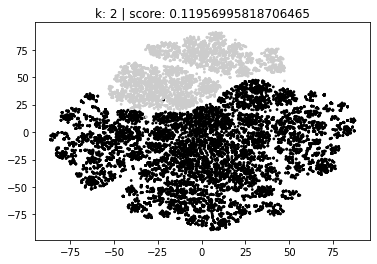

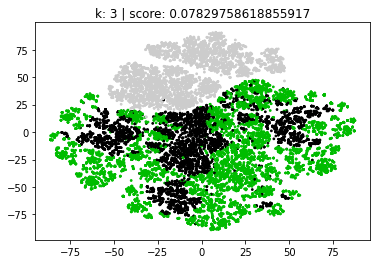

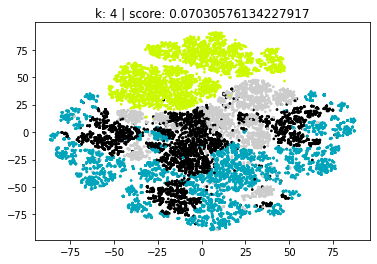

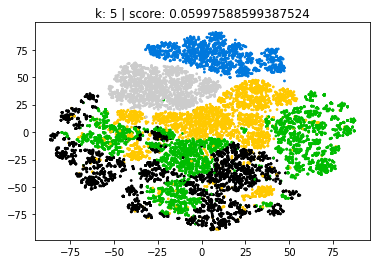

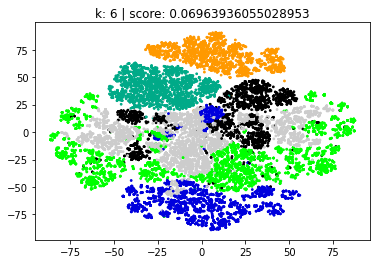

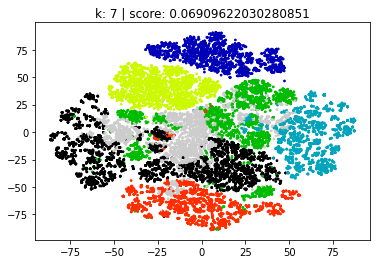

In [26]:
scores_kmeans = []

for k in range(2, 8):
    kmeans = KMeans(k,random_state=1337).fit(X_pca)
    clusters = kmeans.predict(X_pca)
    score = silhouette_score(X_pca, clusters)
    scores_kmeans.append(score)
    plt.title('k: '+ str(k) + ' | score: '+ str(score))
    plt.scatter(tsne[:, 0], tsne[:, 1], s=3, c=clusters, cmap='nipy_spectral') # visualización tsne
    plt.show()

### SPECTRAL CLUSTERING

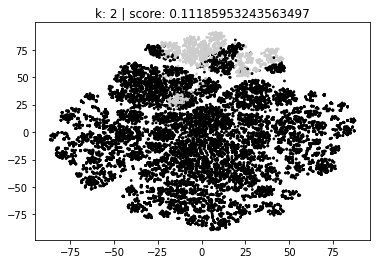

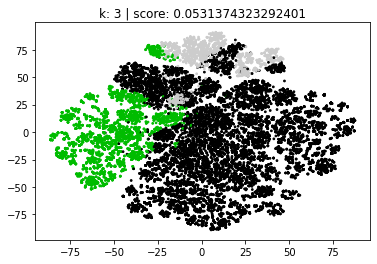

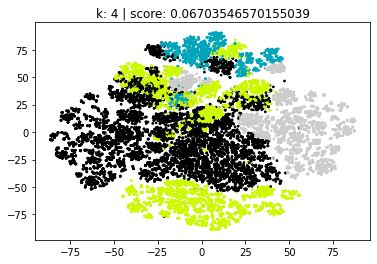

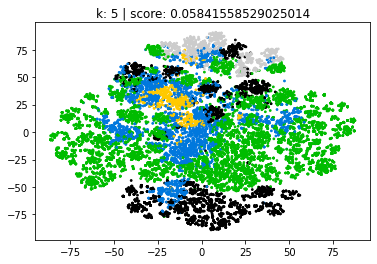

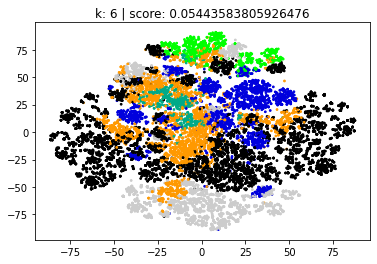

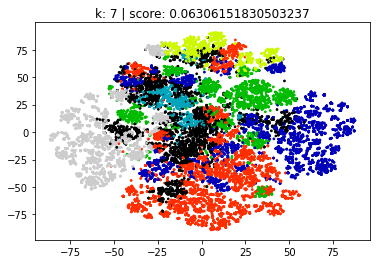

In [27]:
scores_spectral = []

for k in range(2, 8):
    clusters = SpectralClustering(k,random_state=1337).fit_predict(X_pca)
    score = silhouette_score(X_pca, clusters)
    scores_spectral.append(score)
    plt.title('k: '+ str(k) + ' | score: '+ str(score))
    plt.scatter(tsne[:, 0], tsne[:, 1], s=3, c=clusters, cmap='nipy_spectral')
    plt.show()

### CLUSTERING AGLOMERATIVO

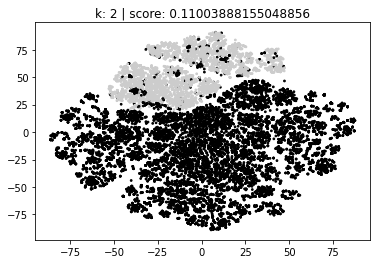

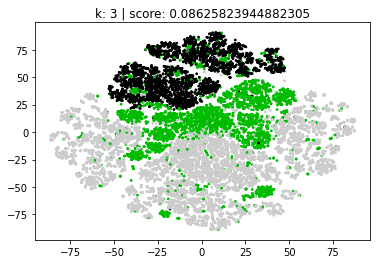

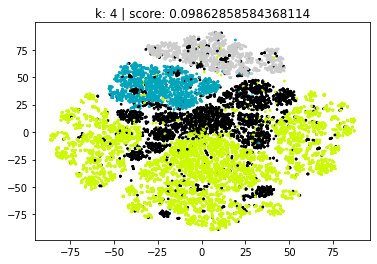

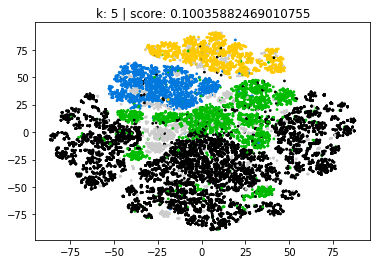

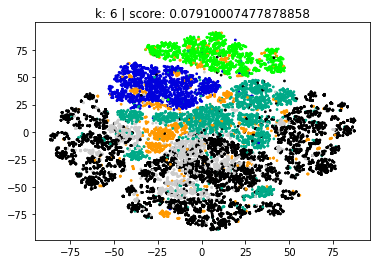

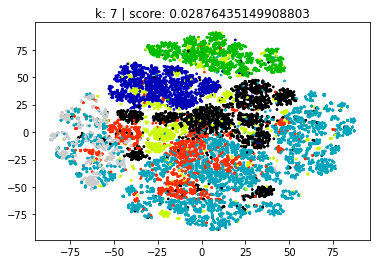

In [28]:
# Probamos con el clsutering aglomerativo

scores_agg = []
for k in range(2, 8):
    clusters = AgglomerativeClustering(k).fit_predict(X_pca)
    score = silhouette_score(X_pca, clusters)
    scores_agg.append(score)
    plt.title('k: '+ str(k) + ' | score: '+ str(score))
    plt.scatter(tsne[:, 0], tsne[:, 1], s=3, c=clusters, cmap='nipy_spectral')
    plt.show()

### DBSCAN

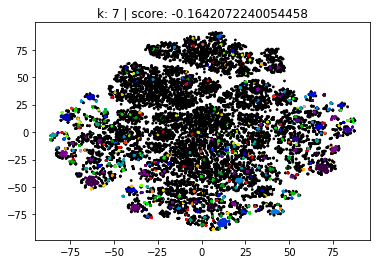

error for eps= 3.2857142857142856
error for eps= 6.071428571428571
error for eps= 8.857142857142858
error for eps= 11.642857142857142
error for eps= 14.428571428571427
error for eps= 17.214285714285715
error for eps= 20.0


In [29]:
scores_dbscan = []

for e in np.linspace(0.5, 20, 8):
    try:
      clusters = DBSCAN(e).fit_predict(X_pca)
      score = silhouette_score(X_pca, clusters)
      scores_dbscan.append(score)
      plt.title('k: '+ str(k) + ' | score: '+ str(score))
      plt.scatter(tsne[:, 0], tsne[:, 1], s=3, c=clusters, cmap='nipy_spectral')
      plt.show()
    except:
      print('error for eps=', e)

### INTENTO CON ISOMAP

También intentamos repetir el mismo proceso, pero con los datos obtenidos mediante el Isomap.

Como al ejecutar Isomap nos devolvió un error de RAM (**foto adjuntada al final de la práctica**), lo hemos dejado comentado para dejar constancia de nuestros intentos.

In [ ]:
"""
scores_kmeans_isomap = []

for k in range(2, 8):
    kmeans = KMeans(k,random_state=1337).fit(X_isomap)
    clusters = kmeans.predict(X_isomap)
    score = silhouette_score(X_isomap, clusters)
    scores_kmeans_isomap.append(score)
    plt.title('KMEANS, k: '+ str(k) + ' | score: '+ str(score))
    plt.scatter(tsne[:, 0], tsne[:, 1], s=3, c=clusters, cmap='nipy_spectral')
    plt.show()

scores_spectral_isomap = []

for k in range(2, 8):
    clusters = SpectralClustering(k,random_state=1337).fit_predict(X_isomap)
    score = silhouette_score(X_isomap, clusters)
    scores_spectral_isomap.append(score)
    plt.title('Spectral, k: '+ str(k) + ' | score: '+ str(score))
    plt.scatter(tsne[:, 0], tsne[:, 1], s=3, c=clusters, cmap='nipy_spectral')
    plt.show()

scores_agg_isomap = []

for k in range(2, 8):
    clusters = AgglomerativeClustering(k).fit_predict(X_isomap)
    score = silhouette_score(X_isomap, clusters)
    scores_agg_isomap.append(score)
    plt.title('AGG, k: '+ str(k) + ' | score: '+ str(score))
    plt.scatter(tsne[:, 0], tsne[:, 1], s=3, c=clusters, cmap='nipy_spectral')
    plt.show()

 """   


## CONCLUSIÓN

El proceso ha sido el siguiente:

Hemos procesado los datos de la siguiente forma:
  - Los datos numéricos (age) los pasamos a través de un MinMaxScaler
  - Reducimos la categoria education a 3 niveles
  - Hacemos una selección de datos categóricos y los transformamos con OneHot Encoding.
  - Los datos textuales los agrupamos en una misma features y aplicamos un CountVectorizer y después un LDA para obtener una distribución de topics de lo que hablan esas personas.
  - Después utilizamos un PCA para reducir la dimensionalidad de nuestras features. Utilizamos un número de componenetes que sean capaces de explicar el 98% de la varianza para no perder demasiada información.

Por otro lado, para visualizar los datos en 2D entrenamos un TSNE que nos permite reducir la dimensionalidad manteniendo lo más posible las distancias entre los elementos. De esta forma nos ayuda a la mejor comprensión de los datos mediante su representación. Esa misma visualización la usaremos cuando asignemos clusters a los puntos.

Para evaluar los algoritmos de clustering, utilizamos el silhouette score. El valor de este score varía entre [-1, +1], siendo los valores cercanos a +1 los mejores. Utilizaremos este score para elegir qué numero de clusters es mejor.

Los algoritmos de clustering elegidos fueron K-Means, Spectral Clsutering y Agglomerative Clustering, ambos entrenados con los datos dimensionalmente reducidos mediante PCA e Isomap.

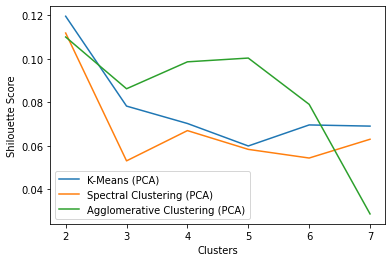

In [31]:
plt.xticks(range(len(range(2, 8))), range(2, 8))
plt.xlabel('Clusters')
plt.ylabel('Shilouette Score')
plt.plot(scores_kmeans, label='K-Means (PCA)')
plt.plot(scores_spectral, label='Spectral Clustering (PCA)')
plt.plot(scores_agg, label='Agglomerative Clustering (PCA)')

# Dejamos también puesto nuestros intentos con Isomap:

# plt.plot(scores_kmeans, label='K-Means (Isomap)')
# plt.plot(scores_spectral, label='Spectral Clustering (Isomap)')
# plt.plot(scores_agg, label='Agglomerative Clustering (Isomap)')

plt.legend()


Viendo la última gráfica podemos observar que el algoritmo con un mayor score es el K-Means con 2 clusters.

También se probó el DBSCAN, pero no dio muy buenos resultados, ya que dejaba a muchos puntos sin asignar un cluster.

También se intentó redicir la dimensionalidad de los datos mediante Isomap, pero nos daba un fallo de memoria, consumía demasiado, esto puede deberse a que el algoritmo "Shortest-path graph search" usado en Isomap es bastande costoso (O(N^2)). Por lo tanto no pudimos entrenar los algoritmos con el dataset reducido mediante isomap. En caso de tener esos datos, habriamos repetido el proceso que hemos hecho con los obtenido con PCA y lo habriamos comparado.

Debajo adjuntamos la imagen del error de memoria RAM al ejecutar ISOMAP:

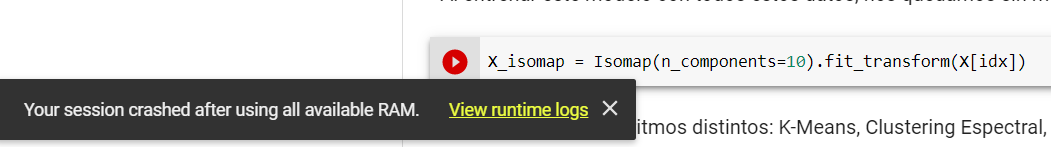